In [2]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so
warnings.filterwarnings("ignore", category=FutureWarning)

# DCA BACKTESTER

In [3]:
df = pd.read_csv('Binance_JUPUSDT_1min.csv')
df = df.iloc[:,:6]
df.columns=['timestamp','open', 'high', 'low', 'close', 'volume']
df.reset_index(drop=True, inplace=True)
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [4]:
def resample_df(df, freq):
    resampled_open = df.open.resample(freq).first()
    resampled_high = df.high.resample(freq).max()
    resampled_low = df.low.resample(freq).min()
    resampled_close = df.close.resample(freq).last()
    resampled_volume = df.volume.resample(freq).sum()
    new_df = pd.concat([resampled_open, resampled_high, resampled_low, resampled_close, resampled_volume], axis=1)
    new_df.dropna(inplace=True)
    return new_df

In [5]:
def calc_price(new_df):
    new_df['price'] = new_df.open.shift(-1)

In [6]:
def calc_rsi(new_df, rsi_length):
    new_df['rsi'] = ta.rsi(new_df.close, length = rsi_length)

In [25]:
def calc_buy_signal(new_df):
    new_df['buy_signal'] = np.where((new_df.rsi<29), True, False)

In [118]:
def backtest(df, freq, rsi_length, tp, base_order, price_deviation, so_amt, so_volume_mult, so_step_mult):

    new_df = resample_df(df, freq)
    calc_price(new_df)
    calc_rsi(new_df, rsi_length)
    calc_buy_signal(new_df)
    new_df.dropna(inplace=True)
    
    #Error handle for no buy signals
    if len(new_df[new_df.buy_signal > 0]) < 1:
        empty_result = pd.DataFrame({
            "entry_time": [0],
            "entry_price": [0],
            "tp_target": [0],
            "sl_target": [0],
            "exit_time": [0],
            "exit_price": [0],
            "pnl": [0],
            "equity": [0],
            "pnl_perc": [0]
        })
        amount = 0
        winrate = 0
        pnl = 0
        equity_float = 0
        #return amount, winrate, pnl_perc, equity_float
        return empty_result
    
    #Initialise Varibles
    in_position = False
    trades = []
    buys = []
    current_trade = {}
    
  

    '''#bot presets
    base_order = 100
    price_deviation = 0.02
    so_amt = 4
    so_volume_mult = 2
    so_step_mult = 2'''

    
    initial_equity = 1000
    equity = initial_equity

    quote_pnl_value = 0
    base_pnl_value = 0

    filled_stages = set()
    order_prices = []
            
    for i in range(len(new_df)-1):
    #Check exit conditions
        if in_position:
            if any(new_df.iloc[i].low < order_price for order_price in order_prices):
                if (len(filled_stages) != len(order_prices)):
                    for j, (order_price, order_volume) in enumerate(zip(order_prices, order_volumes), 1):
                        if j not in filled_stages:
                            if new_df.iloc[i].low< order_price:
                                current_trade["base_amt"] = current_trade["base_amt"] + order_volume / order_price
                                current_trade["quote_size"] = current_trade["quote_size"] + order_volume
                                current_trade["avg_price"] = current_trade["quote_size"]/current_trade["base_amt"]
                                current_trade["stage"] = j
                                current_trade["tp_price"] = current_trade["avg_price"]*tp
                                filled_stages.add(j)
                                
            if new_df.iloc[i].close > current_trade["tp_price"]:
                current_trade["exit_price"] = current_trade["tp_price"]
                base_pnl = current_trade['base_amt'] - (current_trade['quote_size']/current_trade['exit_price'])
                quote_pnl = current_trade['quote_size']*(tp-1)
                pnl_perc = tp - 1
                base_pnl_value += base_pnl
                quote_pnl_value += quote_pnl
                #equity = equity + (equity * pnl_perc)
                #equity_str = "{:.2f}".format(equity)
                trades.append({
                    "entry_time":current_trade["entry_time"],
                    "entry_price":current_trade["entry_price"],
                    "tp_target":current_trade["tp_price"],
                    "exit_time":new_df.iloc[i].name,
                    "exit_price":current_trade["exit_price"], #changed this line
                    "base_amt":current_trade["base_amt"],
                    "quote_size":current_trade["quote_size"],
                    "avg_price":current_trade["avg_price"],
                    "stage":current_trade["stage"],
                    "pnl_perc": pnl_perc,
                    
                    #"equity": equity,
                    "base_profit":base_pnl,
                    "quote_profit":quote_pnl,
                    "cum_base_pnl":base_pnl_value,
                    "cum_quote_pnl":quote_pnl_value,
                    "trade_duration":(new_df.iloc[i].name - current_trade["entry_time"]).total_seconds()/3600
                })
                current_trade = {}
                filled_stages.clear()  # Clear the set to make it empty for the next iteration
                order_prices = []
                in_position = False

            elif new_df.iloc[i].high > current_trade["tp_price"]:
                # Check if the low price has not crossed any order prices
                if not any(new_df.iloc[i].low < order_price for order_price in order_prices):
                    current_trade["exit_price"] = current_trade["tp_price"]
                    base_pnl = current_trade['base_amt'] - (current_trade['quote_size'] / current_trade['exit_price'])
                    quote_pnl = current_trade['quote_size'] * (tp - 1)
                    pnl_perc = tp - 1
                    base_pnl_value += base_pnl
                    quote_pnl_value += quote_pnl
                    trades.append({
                        "entry_time": current_trade["entry_time"],
                        "entry_price": current_trade["entry_price"],
                        "tp_target": current_trade["tp_price"],
                        "exit_time": new_df.iloc[i].name,
                        "exit_price": current_trade["exit_price"],
                        "base_amt": current_trade["base_amt"],
                        "quote_size": current_trade["quote_size"],
                        "avg_price": current_trade["avg_price"],
                        "stage": current_trade["stage"],
                        "pnl_perc": pnl_perc,
                        "base_profit": base_pnl,
                        "quote_profit": quote_pnl,
                        "cum_base_pnl": base_pnl_value,
                        "cum_quote_pnl": quote_pnl_value,
                        "trade_duration": (new_df.iloc[i].name - current_trade["entry_time"]).total_seconds() / 3600
                    })
                    current_trade = {}
                    filled_stages.clear()
                    order_prices = []
                    in_position = False

        #Check entry conditions
        if not in_position:
            if new_df.iloc[i].buy_signal == True:
                current_trade["entry_time"] = new_df.iloc[i+1].name
                current_trade["entry_price"] = new_df.iloc[i].price
                current_trade["tp_price"] = new_df.iloc[i].price*tp
                current_trade["base_amt"] = base_order/new_df.iloc[i].price
                current_trade["quote_size"] = base_order
                current_trade["avg_price"] = base_order/current_trade["base_amt"]
                current_trade["stage"] = 0
                current_trade["base_profit"] = 0
                current_trade["quote_profit"] = 0
                current_trade["trade_duration"] = 0
                in_position = True
                order_prices = [current_trade['entry_price'] * (1 - price_deviation * (so_step_mult ** (i - 1))) for i in range(1, so_amt + 1)]
                for order_price in order_prices:
                    current_trade[f'order_{order_prices.index(order_price)}'] = order_price
                order_volumes = [base_order * (so_volume_mult ** (i-1)) for i in range(1, so_amt +1)]
                #print(f'took trade at {current_trade["entry_price"]}')
                
                
    data = pd.DataFrame(trades)
    amount = len(data)
    #winrate = round(len(data.loc[data.pnl.values>0])/len(data)*100,2)
    #cum_pnl_perc = round(sum(pd.Series(data.pnl_perc))*100,2)
    #equity_value = round(data.equity[len(data) - 1], 2)
    #pnl = round(float(data.equity[len(data) - 1]) - initial_equity,2)
    length = data.exit_time[len(data)-1] - data.entry_time[0]
    #max_drawdown = 100 - data.equity.min()/initial_equity*100
    #equity_high = round(data.equity.max(),2)
    #equity_low = round(data.equity.min(),2)
    
    """print(f"Winrate: {winrate}%")
    print(f"Amount of trades: {amount}")
    print(f"Culmulative pnl: {cum_pnl_perc}%")
    print("")
    print(f"Max drawdown: {max_drawdown} %")
    print(f"Equity Max: {equity_high} USD")
    print(f"Equity Min: {equity_low} USD")
    print(f"Final equity value: {equity_value} USD")
    print("")
    print(f"Summary: ${pnl} profit made from ${initial_equity} initial in about {length} hours & minutes")"""
    #return winrate, amount, cum_pnl_perc, max_drawdown, equity_value
    return data

In [119]:
#def backtest(df, freq, rsi_length, tp, base_order, price_deviation, so_amt, so_volume_mult, so_step_mult):

In [179]:
trades = backtest(df, "1H", 9, 1.02, 20, 0.02, 7, 2, 2)
trades.tail(5)

,entry_time,entry_price,tp_target,exit_time,exit_price,base_amt,quote_size,avg_price,stage,pnl_perc,base_profit,quote_profit,cum_base_pnl,cum_quote_pnl,trade_duration
34,2024-04-13 20:00:00,0.9054,0.822020,2024-04-13 20:00:00,0.822020,397.070402,320,0.805902,4,0.02,7.785694,6.4,62.093498,52.0,0.0
35,2024-04-13 21:00:00,0.8282,0.823409,2024-04-13 21:00:00,0.823409,99.100253,80,0.807263,2,0.02,1.943142,1.6,64.036640,53.6,0.0
36,2024-04-15 19:00:00,0.9896,1.009392,2024-04-15 19:00:00,1.009392,20.210186,20,0.989600,0,0.02,0.396278,0.4,64.432919,54.0,0.0
37,2024-04-16 05:00:00,0.9533,0.972366,2024-04-16 05:00:00,0.972366,20.979755,20,0.953300,0,0.02,0.411368,0.4,64.844286,54.4,0.0
38,2024-04-16 16:00:00,0.9106,0.928812,2024-04-16 16:00:00,0.928812,21.963541,20,0.910600,0,0.02,0.430658,0.4,65.274944,54.8,0.0


In [180]:
trades.quote_size.max()

640

# Visualise

In [173]:
#prep_df:
new_df = resample_df(df, "1H")
calc_price(new_df)
calc_rsi(new_df, 14)
calc_buy_signal(new_df)

In [174]:
trade_duration = sum(trades.trade_duration)
trade_avg = round(trades.trade_duration.mean(),2)
total_duration = (new_df.iloc[-1].name - new_df.iloc[0].name).total_seconds()/3600
ratio = round((trade_duration/total_duration)*100, 2)
print(f'In the market for {trade_duration} hours of {total_duration} total hours. In position for {ratio} % of the total time with an average trade duration of {trade_avg} hours')

In the market for 289.0 hours of 1826.0 total hours. In position for 15.83 % of the total time with an average trade duration of 11.12 hours


In [175]:
new_df

,open,high,low,close,volume,price,rsi,buy_signal
timestamp,,,,,,,,
2024-01-31 16:00:00,0.0300,0.8720,0.0300,0.6909,172086604.7,0.6911,NaN,False
2024-01-31 17:00:00,0.6911,0.7199,0.6675,0.6841,39067113.8,0.6842,0.000000,True
2024-01-31 18:00:00,0.6842,0.6950,0.6668,0.6775,22960334.0,0.6771,0.000000,True
2024-01-31 19:00:00,0.6771,0.6784,0.6364,0.6395,26964426.0,0.6395,0.000000,True
2024-01-31 20:00:00,0.6395,0.6498,0.6211,0.6297,21008797.9,0.6296,0.000000,True
...,...,...,...,...,...,...,...,...
2024-04-16 14:00:00,0.9402,0.9569,0.9294,0.9329,3478753.2,0.9326,35.588790,False
2024-04-16 15:00:00,0.9326,0.9381,0.9101,0.9107,3113637.5,0.9106,32.034187,False
2024-04-16 16:00:00,0.9106,0.9468,0.8986,0.9468,3370053.4,0.9470,42.152368,False


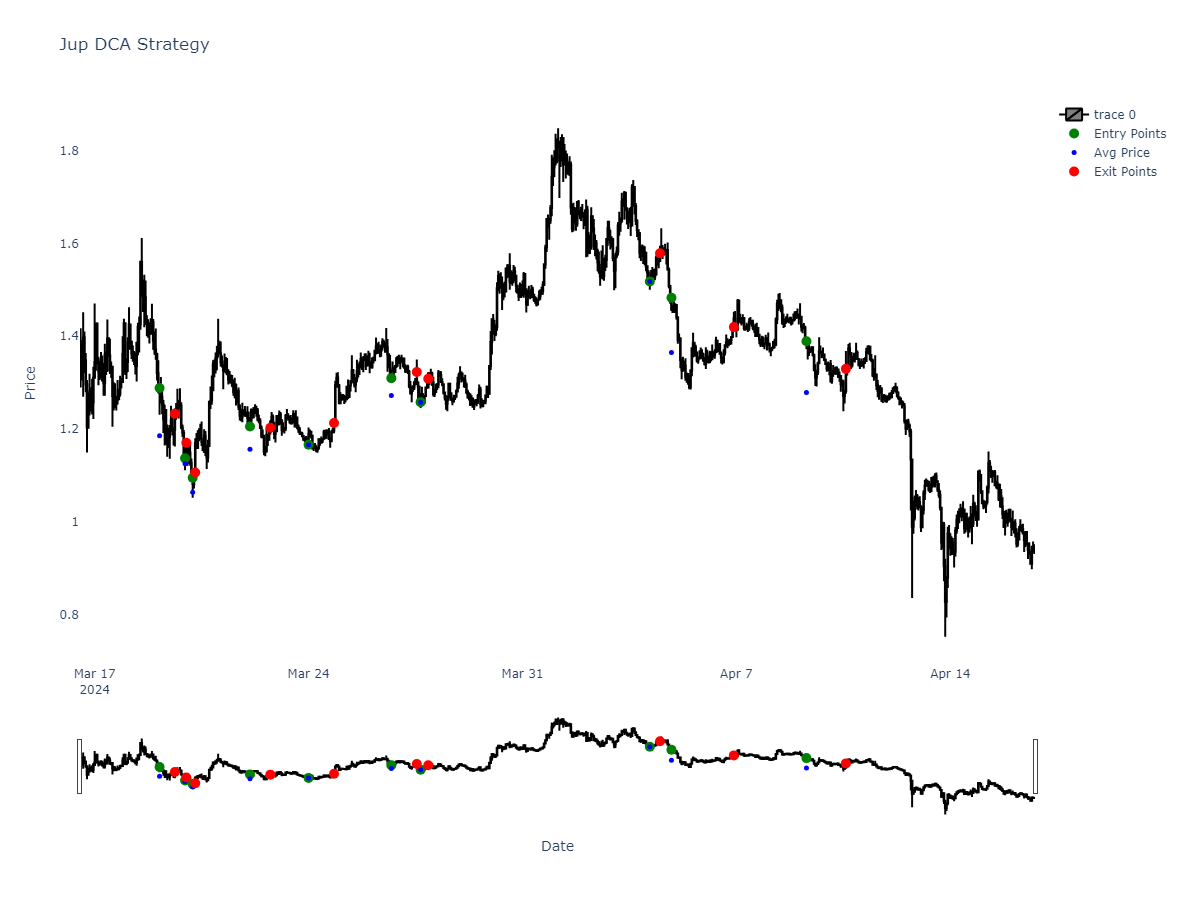

In [176]:
bars = 750
cutoff_time = new_df.index[-bars]
trades_slice = trades[trades['entry_time'] >= cutoff_time]

# Create a candlestick chart
fig = go.Figure(data=[go.Candlestick(x=new_df.index[-bars:],
                open=new_df['open'].tail(bars),
                high=new_df['high'].tail(bars),
                low=new_df['low'].tail(bars),
                close=new_df['close'].tail(bars),increasing_line_color= 'black', decreasing_line_color= 'black')])

# Add scatter plots for entry and exit points
entry_points = dict(x=trades_slice['entry_time'], y=trades_slice['entry_price'], text=['Buy'] * len(trades_slice), mode='markers', name='Entry Points', marker=dict(color='green', size=10))
avg_price = dict(x=trades_slice['entry_time'], y=trades_slice['avg_price'], text=['Avg'] * len(trades_slice), mode='markers', name='Avg Price', marker=dict(color='blue', size=5))
exit_points = dict(x=trades_slice['exit_time'], y=trades_slice['exit_price'], text=['Sell'] * len(trades_slice), mode='markers', name='Exit Points', marker=dict(color='red', size=10))

# Add entry and exit points to the figure
#fig.add_trace(go.Scatter(x=new_df.index, y=new_df['pdLow'], mode='lines', name='Previous Day Low'))
#fig.add_trace(go.Scatter(x=new_df.index[-bars:], y=new_df['fast_ma'][-bars:], mode='lines', name='fast_sma', line=dict(color='blue')))
#fig.add_trace(go.Scatter(x=new_df.index[-bars:], y=new_df['slow_ma'][-bars:], mode='lines', name='slow_sma', line=dict(color='black')))
fig.add_trace(go.Scatter(entry_points))
fig.add_trace(go.Scatter(avg_price))
fig.add_trace(go.Scatter(exit_points))

# Update layout
fig.update_layout(title='Jup DCA Strategy', xaxis_title='Date', yaxis_title='Price', width=1200, height=900, plot_bgcolor='white', yaxis=dict(showgrid=False), xaxis=dict(showgrid=False))

# Show the figure
fig.show()